# TOI 2266.01 joint analysis

**Author:** Hannu Parviainen </br>
**Last modified:** 13. December 2023

Here we model both the space- and ground-based light curves simultaneously with a model that accounts for possible light contamination from an unresolved source inside the photometry apertures.

## Set up multithreading and multiprocessing

In [1]:
import os
nt = 1
os.environ["OMP_NUM_THREADS"] =        str(nt)
os.environ["OPENBLAS_NUM_THREADS"] =   str(nt)
os.environ["MKL_NUM_THREADS"] =        str(nt)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(nt)
os.environ["NUMEXPR_NUM_THREADS"] =    str(nt)

from numba import set_num_threads, config
config.THREADING_LAYER = 'safe'
set_num_threads(nt)

from multiprocessing import Pool

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
%run toi_2266.py

In [4]:
lpf = LPF('TOI-2266.01-joint-contaminated', m2_passbands=('r', 'i', 'z_s'), downsample=1)

In [6]:
lpf.ps

[  0 |G| tc             N(μ = 2459255.6937865, σ = 0.025)        [    -inf ..      inf],
   1 |G| p              N(μ = 2.326214, σ = 0.000223)            [    0.00 ..      inf],
   2 |G| rho            U(a = 5, b = 35)                         [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2_app         U(a = 0.0004, b = 0.0064)                [    0.00 ..      inf],
   5 |G| k2_true        U(a = 0.0004, b = 0.9025)                [    0.00 ..      inf],
   6 |G| teff_h         N(μ = 3200.0, σ = 160.0)                 [ 2500.00 .. 12000.00],
   7 |G| teff_c         U(a = 2500, b = 12000)                   [ 2500.00 .. 12000.00],
   8 |G| k2_app_tess    U(a = 0.0004, b = 0.0064)                [    0.00 ..      inf],
   9 |P| q1_tess        N(μ = 0.78, σ = 0.008)                   [    0.00 ..     1.00],
  10 |P| q2_tess        N(μ = 0.69, σ = 0.124)                   [    0.00 ..     1.00],
  11 |P| q1_g        

In [5]:
def lnpost(pvp):
    return squeeze(lpf.lnposterior(pvp))

In [15]:
class Analysis:
    def __init__(self, lpf, use_mp: bool = False, mp_processes: int = 16):
        self.use_mp = use_mp
        self.mp_processes = mp_processes
        self.lpf = lpf

        if use_mp:
            self.pool = Pool(self.mp_processes)
        else:
            self.pool = None
            
    def optimize(self, niter: int = 1500, npop: int = 600, population=None):
        if self.use_mp:
            self.lpf.optimize_global(niter=niter, npop=npop, population=population, pool=self.pool, lnpost=lnpost, vectorize=False)
        else:
            self.lpf.optimize_global(niter=niter, npop=npop, population=population, )
        
    def sample(self, niter: int = 1500, thin: int = 100, repeats: int = 1, save: bool = True, population = None):
        if self.use_mp:
            lpf.sample_mcmc(niter, thin=thin, population=population, repeats=repeats, save=save, pool=self.pool, lnpost=lnpost, vectorize=False)
        else:
            lpf.sample_mcmc(niter, thin=thin, population=population, repeats=repeats, save=save)

In [16]:
an = Analysis(lpf, use_mp=True)

Global optimisation:   0%|          | 0/10 [00:00<?, ?it/s]

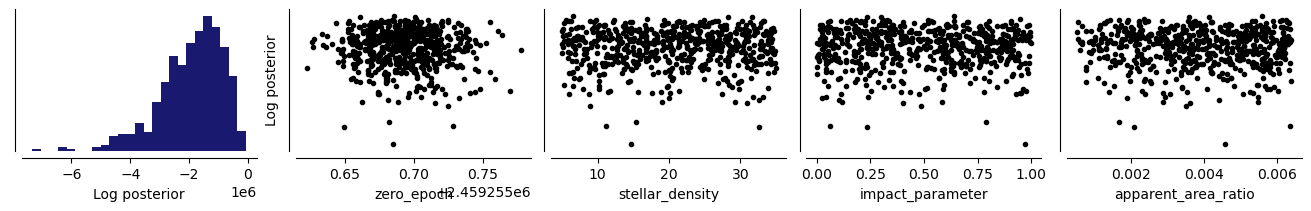

In [17]:
an.optimize(10)

Global optimisation:   0%|          | 0/25000 [00:00<?, ?it/s]

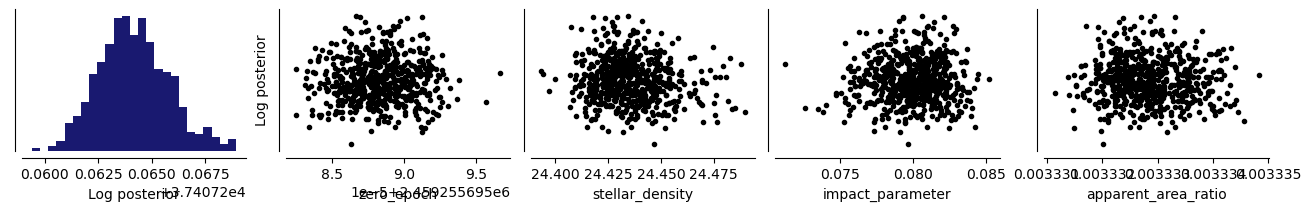

In [8]:
an.optimize(25000)

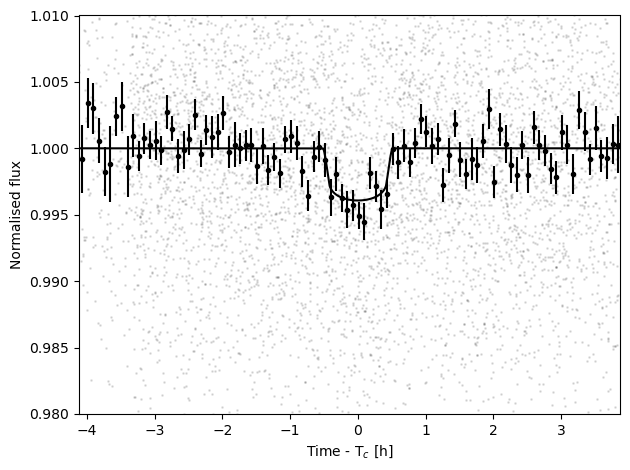

In [9]:
lpf.plot_folded_tess_transit(binwidth=5, ylim=(0.98, 1.01));

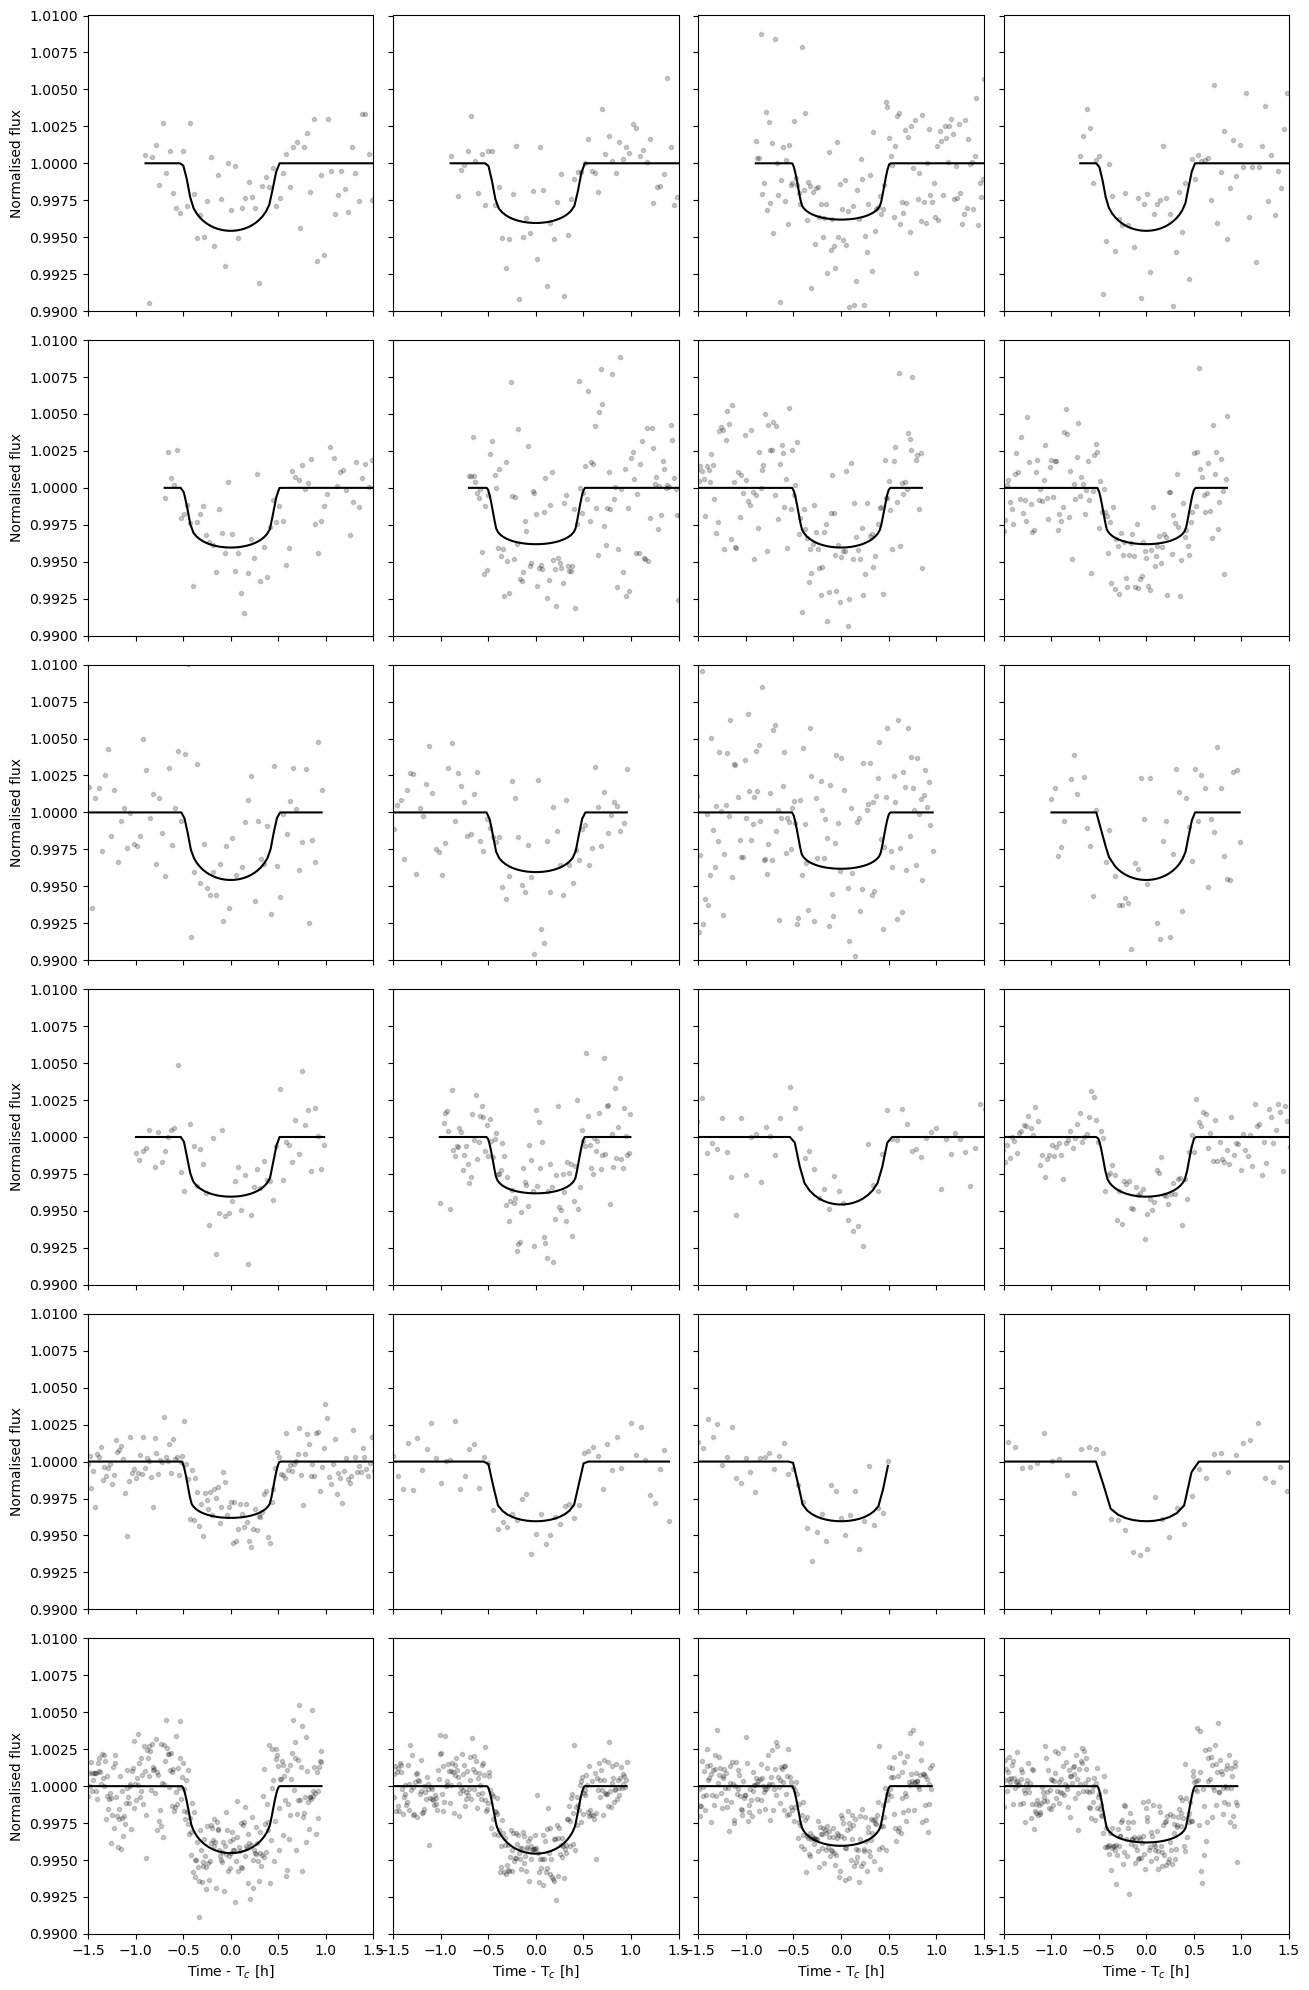

In [10]:
lpf.plot_gb_transits(figsize=(13,20), remove_baseline=True, xlim=(-1.5, 1.5), ylim=(0.99, 1.01));

In [17]:
lpf.set_prior('rho', 'UP', 5, 35)

In [21]:
an.sample(25000, 250, 8)

MCMC sampling:   0%|          | 0/8 [00:00<?, ?it/s]

Run 1/8:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 2/8:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 3/8:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 4/8:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 5/8:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 6/8:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 7/8:   0%|          | 0/25000 [00:00<?, ?it/s]

Run 8/8:   0%|          | 0/25000 [00:00<?, ?it/s]

---
<center>©2023 Hannu Parviainen</center>